In [1]:
from imutils import paths
from lxml import etree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import os
import glob

In [2]:
#confirm the current working directory
os.getcwd()

'C:\\Users\\mattr\\Documents\\dog_breed'

In [3]:
# grab the image paths and randomly shuffle them
imagePaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\Images'))

In [4]:
tree = etree.parse(r'C:\\Users\\mattr\\Documents\\dog_breed\\Annotation\\n02085620-Chihuahua/n02085620_199')
root = tree.getroot()

In [5]:
os.chdir(r'C:\\Users\\mattr\\Documents\\dog_breed\\Annotation')

annotations = glob.glob('*')

In [6]:
filename_list = []
breed_list = []
width_list = []
height_list = []
xmin_list = []
xmax_list = []
ymin_list = []
ymax_list = []
croppedx_list = []
croppedy_list = []

for folder in annotations:
    path = ('C:\\Users\\mattr\\Documents\\dog_breed\\Annotation\\'+folder)
    breed = path.split('-',1)[1]
    os.chdir(path)
    myFiles = glob.glob('*')
    for file in myFiles:
        tree = etree.parse(file)
        root = tree.getroot()
        filename_tag = root.find('filename')
        filename = filename_tag.text

        object_tag = root.find('object')
        name = object_tag.find('name')
        label = name.text
        bndbox = object_tag.find('bndbox')
        xmin = bndbox.find('xmin')
        xmax = bndbox.find('xmax')
        ymin = bndbox.find('ymin')
        ymax = bndbox.find('ymax')
        
        size_tag = root.find('size')
        width = size_tag.find('width')
        height = size_tag.find('height')
        wtext = width.text
        htext = height.text
        xmin = xmin.text
        xmax = xmax.text
        ymin = ymin.text
        ymax = ymax.text
        
        filename_list.append(filename)
        breed_list.append(breed)
        width_list.append(wtext)
        height_list.append(htext)
        xmin_list.append(int(xmin))
        xmax_list.append(int(xmax))
        ymin_list.append(int(ymin))
        ymax_list.append(int(ymax))
        
        croppedx_list.append(int(xmax) - int(xmin))
        croppedy_list.append(int(ymax) - int(ymin))

In [7]:
dims = pd.DataFrame({'width':width_list, 
                     'height':height_list,
                     'cropped_width': croppedx_list,
                     'cropped_height': croppedy_list})

In [8]:
dims['height'] = dims['height'].astype(int)
dims['width'] = dims['width'].astype(int)
dims['cropped_width'] = dims['cropped_width'].astype(int)
dims['cropped_height'] = dims['cropped_height'].astype(int)

In [9]:
dims.describe(percentiles=[0.05,.1,.25,.5,.75,.9,.95])

,width,height,cropped_width,cropped_height
count,20580.000000,20580.000000,20580.000000,20580.000000
mean,442.531876,385.861224,289.040671,297.629932
std,142.792308,124.863446,128.577818,119.853244
min,97.000000,100.000000,32.000000,38.000000
5%,221.000000,210.000000,119.000000,137.000000
10%,288.000000,259.000000,147.000000,165.000000
25%,361.000000,333.000000,200.000000,220.000000
50%,500.000000,375.000000,279.000000,291.000000
75%,500.000000,453.000000,362.000000,357.000000
90%,500.000000,500.000000,441.000000,436.000000


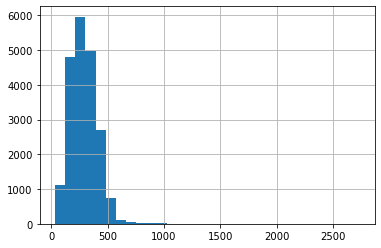

In [10]:
dims.cropped_width.hist(bins=30)

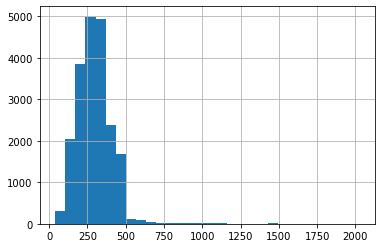

In [11]:
dims.cropped_height.hist(bins=30)

In [12]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

X = []
y = []

# loop over the input images
for index, imagePath in enumerate(imagePaths):
    try:
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
    #     image = tf.image.resize_with_pad(image, 300, 300, method=tf.image.ResizeMethod.BICUBIC)
    #     image = tf.image.random_crop(image, (300,300,3), seed=123)
    #     image = tf.image.resize_with_crop_or_pad(image, 300, 300)
        image = tf.image.crop_to_bounding_box(image, 
                                  ymin_list[index], 
                                  xmin_list[index], 
                                  (ymax_list[index] - ymin_list[index]),
                                  (xmax_list[index] - xmin_list[index]))
        image = cv2.resize(np.array(image), (288, 288), interpolation = cv2.INTER_AREA)
        image = img_to_array(image)
        image = image/255
        X.append(image)
        y.append(breed_list[index])
    except:
        pass

Using TensorFlow backend.


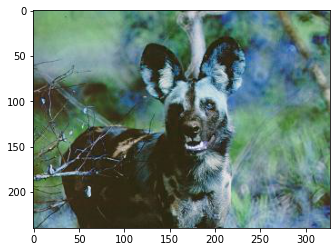

In [13]:
testimage = cv2.imread(imagePaths[index])
plt.imshow(testimage)

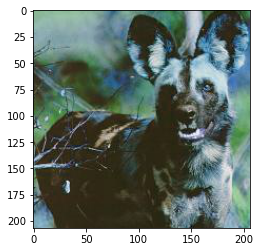

In [14]:
test1 = tf.image.crop_to_bounding_box(testimage, 
                              ymin_list[index], 
                              xmin_list[index], 
                              (ymax_list[index] - ymin_list[index]),
                              (xmax_list[index] - xmin_list[index]))

plt.imshow(test1)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [16]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                   random_state = 123)

In [18]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [19]:
np.shape(X_train)

(18520, 288, 288, 3)

In [20]:
np.shape(y_train)

(18520,)

In [21]:
from keras.utils import to_categorical

# convert the labels from integers to vectors
y_train = to_categorical(y_train, num_classes=120)
y_test = to_categorical(y_test, num_classes=120)

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [23]:
tf.keras.backend.clear_session()

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
 
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


### Use VGG16 pretrained model

In [24]:
# from keras.applications.vgg16 import VGG16
# vgg16 = Sequential()
# vgg16.add(VGG16(include_top=False, weights='imagenet', input_shape=(200,200,3), pooling=max))
# vgg16.add(Flatten())
# # vgg16.add(Dense(480, activation='relu'))
# # vgg16.add(Dense(240, activation='relu'))
# vgg16.add(Dense(120, activation='softmax'))

In [25]:
# print(vgg16.summary())

In [26]:
# vgg16.layers[0].trainable = False

In [27]:
# vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', 
#                    verbose=1, restore_best_weights=True, patience=5)

# vgg16.fit(X_train, y_train, batch_size=32, 
#           epochs=20, shuffle=True,
#          validation_split=0.25, callbacks=[es])

In [29]:
# score = vgg16.evaluate(X_test, y_test, batch_size=32)
# print(score)

In [30]:
# preds = le.inverse_transform(vgg16.predict_classes(X_test))

In [31]:
# i = 1215

# plt.imshow(X_test[i])

In [32]:
# preds[i]

In [33]:
# le.inverse_transform(y_test[i])

In [34]:
# from keras.applications.vgg19 import VGG19
# vgg19 = Sequential()
# vgg19.add(VGG19(include_top=False, weights='imagenet', input_shape=(300,300,3), pooling=max))
# vgg19.add(Flatten())
# vgg19.add(Dense(120, activation='softmax'))

In [35]:
# print(vgg19.summary())

In [36]:
# vgg19.layers[0].trainable = False

In [37]:
# vgg19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
# # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', 
#                    verbose=1, restore_best_weights=True, patience=5)

# vgg19.fit(X_train, y_train, batch_size=32, 
#           epochs=20, shuffle=True,
#          validation_split=0.25, callbacks=[es])

In [39]:
# from keras.applications.resnet50 import ResNet50
# resnet50 = Sequential()
# resnet50.add(ResNet50(include_top=False, weights='imagenet', input_shape=(160,160,3), pooling=max))
# resnet50.add(Flatten())
# resnet50.add(Dense(120, activation='softmax'))

In [40]:
# print(resnet50.summary())

In [41]:
# resnet50.layers[0].trainable = False

In [42]:
# resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', 
#                    verbose=1, restore_best_weights=True, patience=5)

# resnet50.fit(X_train, y_train, batch_size=32, 
#           epochs=20, shuffle=True,
#          validation_split=0.25, callbacks=[es])

## InceptionV3 Model

In [44]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [45]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [46]:
# create the base pre-trained model
base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(288,288,3))

In [47]:
# add a global spatial average pooling layer
x = base.output
# let's add a fully-connected layer
x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(120, activation='softmax')(x)

# predictions = Dense(120, name='dense_logits')(x)
# predictions = Activation('softmax', dtype='float32', name='predictions')(predictions)

In [48]:
# this is the model we will train
inc_v3 = Model(inputs=base.input, outputs=predictions)

In [49]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base.layers:
    layer.trainable = False

In [50]:
sgd = SGD(lr=0.0001)
inc_v3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [51]:
# fits the model on batches with real-time data augmentation:
inc_v3.fit_generator(datagen.flow(X_train, y_train, batch_size=8),
                    steps_per_epoch=len(X_train) / 8, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
2315/2315 [==============================] - 380s 164ms/step - loss: 3.6016 - accuracy: 0.2538 - val_loss: 1.4786 - val_accuracy: 0.6696
Epoch 2/10
2315/2315 [==============================] - 332s 143ms/step - loss: 2.1760 - accuracy: 0.5032 - val_loss: 0.9174 - val_accuracy: 0.7430
Epoch 3/10
2315/2315 [==============================] - 326s 141ms/step - loss: 1.7853 - accuracy: 0.5666 - val_loss: 0.7875 - val_accuracy: 0.7614
Epoch 4/10
2315/2315 [==============================] - 321s 138ms/step - loss: 1.5899 - accuracy: 0.6012 - val_loss: 0.7711 - val_accuracy: 0.7775
Epoch 5/10
2315/2315 [==============================] - 321s 139ms/step - loss: 1.4751 - accuracy: 0.6215 - val_loss: 0.7435 - val_accuracy: 0.7809
Epoch 6/10
2315/2315 [==============================] - 317s 137ms/step - loss: 1.3966 - accuracy: 0.6373 - val_loss: 0.7324 - val_accuracy: 0.7862
Epoch 7/10
2315/2315 [==============================] - 316s 137ms/step - loss: 1.3515 - accuracy: 0.6444 - val_

In [52]:
# simple early stopping
# es = EarlyStopping(monitor='val_accuracy', mode='min', 
#                    verbose=1, restore_best_weights=True, patience=2)

# inc_v3.fit(X_train, y_train, batch_size=32, 
#           epochs=5, shuffle=True,
#          validation_split=0.1)

In [53]:
# for i, layer in enumerate(base.layers):
#    print(i, layer.name)

In [54]:
# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in inc_v3.layers[:309]:
#    layer.trainable = False
# for layer in inc_v3.layers[309:]:
#    layer.trainable = True

In [55]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# inc_v3.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
# # simple early stopping
# es = EarlyStopping(monitor='val_accuracy', mode='min', 
#                    verbose=1, restore_best_weights=True, patience=2)

# inc_v3.fit(X_train, y_train, batch_size=32, 
#           epochs=5, shuffle=True,
#          validation_split=0.1)

In [57]:
score = inc_v3.evaluate(X_test, y_test, batch_size=32)
print(score)

2058/2058 [==============================] - 26s 12ms/step
[0.7228100188040293, 0.7973760962486267]


In [58]:
inc_v3_preds = inc_v3.predict(X_test)

In [59]:
inc_v3_preds_final = le.inverse_transform(np.argmax(inc_v3_preds,axis=1))

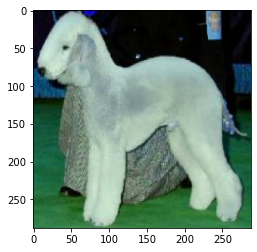

In [60]:
i = 26

plt.imshow(X_test[i])

In [61]:
inc_v3_preds_final[i]

'Bedlington_terrier'

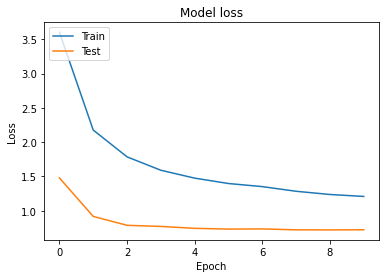

In [62]:
hist = inc_v3.history

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Classify Mani to test accuracy

In [63]:
# grab the image paths and randomly shuffle them
maniPaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\Mani'))

In [64]:
# mani_pics = []

# # loop over the input images
# for idx, path in enumerate(maniPaths):
#     # load the image, pre-process it, and store it in the data list
#     image = cv2.imread(path)
# #     image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
# #     image = cv2.resize(image, None, fx = 1.25, fy = 1.25, interpolation = cv2.INTER_AREA)
#     h = np.shape(image)[0]
#     w = np.shape(image)[1]
#     cropsize = 150
#     if h < cropsize*2:
#         continue    # continue here
#     if w < cropsize*2:
#         continue    # continue here
#     image = image[(h//2 - cropsize):(h//2 + cropsize), (w//2 - cropsize):(w//2 + cropsize)]
#     image = img_to_array(image)
#     image = image/255
#     mani_pics.append(image)

In [65]:
mani_pics = []

# loop over the input images
for mani in maniPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(mani)
    image = cv2.resize(image, (288, 288), interpolation = cv2.INTER_AREA)
#     image = tf.image.resize_with_crop_or_pad(image, 300, 300)
    image = img_to_array(image)
    image = image/255
    mani_pics.append(image)

In [66]:
mani_pics = np.array(mani_pics)

In [67]:
mani_preds = inc_v3.predict(mani_pics)
mani_preds_final = le.inverse_transform(np.argmax(mani_preds,axis=1))

In [68]:
mani_preds_final = pd.Series(mani_preds_final)

In [69]:
print(mani_preds_final[0:30,])

0           Eskimo_dog
1          Appenzeller
2             Cardigan
3        Border_collie
4           Eskimo_dog
5       Siberian_husky
6          toy_terrier
7        Border_collie
8               beagle
9               kelpie
10         toy_terrier
11    English_springer
12            Cardigan
13       Border_collie
14            Cardigan
15      Siberian_husky
16            Pembroke
17          Eskimo_dog
18          Eskimo_dog
19      Siberian_husky
20          Eskimo_dog
21            Pembroke
22       Gordon_setter
23      Siberian_husky
24            Cardigan
25          Eskimo_dog
26            Cardigan
27       Border_collie
28       Border_collie
29       Border_collie
dtype: object


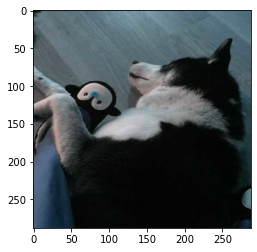

In [70]:
p = 29

plt.imshow(mani_pics[p])

In [71]:
sample = inc_v3.predict(mani_pics[p:p+2])
sample_pred = le.inverse_transform(np.argmax(sample,axis=1))
print(sample_pred)

['Border_collie' 'cocker_spaniel']


In [72]:
len(mani_preds_final)

406

In [73]:
print(mani_preds_final.value_counts())

Eskimo_dog                106
Siberian_husky            100
Cardigan                   56
Border_collie              41
Pembroke                   24
kelpie                     13
German_shepherd             9
malamute                    9
Bernese_mountain_dog        8
Appenzeller                 7
collie                      4
toy_terrier                 4
beagle                      3
schipperke                  2
English_springer            2
EntleBucher                 2
Gordon_setter               2
miniature_pinscher          1
briard                      1
African_hunting_dog         1
Pomeranian                  1
Welsh_springer_spaniel      1
cocker_spaniel              1
giant_schnauzer             1
Saint_Bernard               1
Shetland_sheepdog           1
borzoi                      1
papillon                    1
Chihuahua                   1
Leonberg                    1
Old_English_sheepdog        1
dtype: int64


In [74]:
os.chdir(r'C:\\Users\\mattr\\Documents\\dog_breed')

In [75]:
# serialize weights to HDF5
# 191/406 is best so far
# inc_v3.save_weights("best-dog-model2.h5")

In [76]:
# inc_v3.load_weights('best-dog-model.h5')

In [77]:
# mani_preds = inc_v3.predict(mani_pics)
# mani_preds_final = le.inverse_transform(np.argmax(mani_preds,axis=1))
# mani_preds_final = pd.Series(mani_preds_final)
# print(mani_preds_final.value_counts())

In [78]:
# serialize weights to HDF5
# 163/406 is best so far
# inc_v3.save_weights("best-dog-model.h5")

## Classify Roux to test accuracy

In [82]:
# grab the image paths and randomly shuffle them
rouxPaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\Roux'))

In [83]:
roux_pics = []

# loop over the input images
for roux in rouxPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(roux)
#     image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
    image = tf.image.resize_with_crop_or_pad(image, 288, 288)
    image = img_to_array(image)
    image = image/255
    roux_pics.append(image)
    
roux_pics = np.array(roux_pics)

In [84]:
roux_preds = inc_v3.predict(roux_pics)
roux_preds_final = le.inverse_transform(np.argmax(roux_preds,axis=1))

In [85]:
roux_preds_final = pd.Series(roux_preds_final)
print(roux_preds_final.value_counts())

Labrador_retriever        2
Great_Dane                2
bluetick                  2
Irish_wolfhound           1
Irish_setter              1
Airedale                  1
Welsh_springer_spaniel    1
golden_retriever          1
dtype: int64
